In [3]:
import pandas as pd                                     
import numpy as np                                   
import os                                               
import matplotlib.pyplot as plt                         
import scipy.stats.mstats as ssm                        
from scipy.stats import gaussian_kde as kde
import random

%matplotlib inline

Our first task is to transform the dataset into something meaningfully that we can use in our classifier. To do that we are going to aggregate the data based on the player and we are going to do that in the following way:
    1. Columns: playerShort, club, leagueCountry, birthday, height, weight and, position just get copied
    2. We drop column: player since the playerShort column is unique
    3. Columns: games, victories, ties, defeats, goals, yellowCards, yellowReds and, redCards get summed up
    4. We drop the photoID column
    5. Then we average the rating of the skin colour
    6. We then drop columns: refNum, refCountry and, Alpha_3
    7. We also drop nIAT, nExp, then average meanIAT, meanExp and calculate new seIAT, seExp based on the variance of the values we used in the averaging of meanIAT and meanExp.




In [5]:
df = pd.read_csv('CrowdstormingDataJuly1st.csv')

Let's check that the data was loaded 

In [6]:
df.head(5)

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,...,0.50,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,...,0.75,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504
2,abdon-prats,Abdón Prats,RCD Mallorca,Spain,17.12.1992,181.0,79.0,NaN,1,0,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
3,pablo-mari,Pablo Marí,RCD Mallorca,Spain,31.08.1993,191.0,87.0,Center Back,1,1,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
4,ruben-pena,Rubén Peña,Real Valladolid,Spain,18.07.1991,172.0,70.0,Right Midfielder,1,1,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002


Ok now, let's make the playerShort the index, also let's average the skintone and drop all players that have the skintone as NaN. Plus, we average the player skintone.

In [7]:
#df.set_index(df.columns[0], inplace=True)
df.dropna(subset=['rater1', 'rater2'], inplace=True)
df['skintone']=df[['rater1', 'rater2']].mean(axis=1)
df.head(10)

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp,skintone
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,...,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696,0.375
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,...,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504,0.750
5,aaron-hughes,Aaron Hughes,Fulham FC,England,08.11.1979,182.0,71.0,Center Back,1,0,...,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.125
6,aleksandar-kolarov,Aleksandar Kolarov,Manchester City,England,10.11.1985,187.0,80.0,Left Fullback,1,1,...,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.125
7,alexander-tettey,Alexander Tettey,Norwich City,England,04.04.1986,180.0,68.0,Defensive Midfielder,1,0,...,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,1.000
8,anders-lindegaard,Anders Lindegaard,Manchester United,England,13.04.1984,193.0,80.0,Goalkeeper,1,0,...,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.250
9,andreas-beck,Andreas Beck,1899 Hoffenheim,Germany,13.03.1987,180.0,70.0,Right Fullback,1,1,...,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.000
10,antonio-rukavina,Antonio Rukavina,Real Valladolid,Spain,26.01.1984,177.0,74.0,Right Fullback,2,2,...,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.000
11,ashkan-dejagah,Ashkan Dejagah,Fulham FC,England,05.07.1986,181.0,74.0,Left Winger,1,1,...,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.500
12,benedikt-hoewedes,Benedikt Höwedes,FC Schalke 04,Germany,29.02.1988,187.0,80.0,Center Back,1,1,...,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.000


The next step is to change the format of the data and keep only relevant fields.

In [8]:
df.drop(['player', 'rater1', 'rater2', 'photoID', 'birthday'], inplace=True, axis=1)
df.head()

,playerShort,club,leagueCountry,height,weight,position,games,victories,ties,defeats,...,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp,skintone
0,lucas-wilchez,Real Zaragoza,Spain,177.0,72.0,Attacking Midfielder,1,0,0,1,...,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696,0.375
1,john-utaka,Montpellier HSC,France,179.0,82.0,Right Winger,1,0,0,1,...,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504,0.750
5,aaron-hughes,Fulham FC,England,182.0,71.0,Center Back,1,0,0,1,...,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.125
6,aleksandar-kolarov,Manchester City,England,187.0,80.0,Left Fullback,1,1,0,0,...,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.125
7,alexander-tettey,Norwich City,England,180.0,68.0,Defensive Midfielder,1,0,0,1,...,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,1.000


Now we will collapse these entries so that we have one row per player. We aggregate numerical values either by summing or averaging, and most frequent strings are selected (unless for 

In [9]:
players_grouped = df.groupby(by=['playerShort'])

fdict = dict.fromkeys(['club', 'leagueCountry'], lambda x: x.value_counts().index[0])
fdict.update({'position': lambda x: x.index[0]})
fdict.update(dict.fromkeys(['meanIAT', 'meanExp', 'seIAT', 'seExp', 'height', 'weight', 'skintone'], lambda x: np.mean(x)))
fdict.update(dict.fromkeys(['games', 'victories', 'ties', 'defeats', 'goals', 'yellowCards', 'yellowReds', 'redCards'], np.sum))

data = players_grouped.agg(fdict)
data.reset_index(inplace=True, drop=True)
labels = data[['skintone']]
data.drop('skintone', inplace=True, axis=1)
data.head()

,victories,leagueCountry,seIAT,games,goals,defeats,ties,seExp,meanIAT,weight,club,position,height,yellowReds,yellowCards,meanExp,redCards
0,247,England,0.000652,654,9,228,179,0.004065,0.346459,71.0,Fulham FC,5,182.0,0,19,0.494575,0
1,141,Germany,0.000219,336,62,122,73,0.000993,0.348818,73.0,Werder Bremen,745,183.0,0,42,0.449220,1
2,200,England,0.000367,412,31,115,97,0.002032,0.345893,63.0,Tottenham Hotspur,746,165.0,0,11,0.491482,0
3,150,England,0.003334,260,39,68,42,0.013522,0.346821,76.0,Arsenal FC,747,178.0,0,31,0.514693,1
4,41,France,0.001488,124,1,43,40,0.005296,0.331600,73.0,Montpellier HSC,4418,180.0,4,8,0.335587,2


Now we need to deal with the text features. Our model does not like text features so we have to encode them as numbers. There are two ways of doing this.
1. We relate each text value to a number
2. For each text value we add a new column and set it to 0 where that text value does not appear and 1 where it appers

In general it it suggested to use the second aproach, but in our case I will use the first aproach for 2 reasons: 
-There are a lot of clubs and that will add a lot of columns
-It will make it very dificult to inspect the feature_importances_

In [45]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le1 = preprocessing.LabelEncoder()
le2 = preprocessing.LabelEncoder()
le.fit(data['leagueCountry'])
le1.fit(data['club'])
le2.fit(data['position'].dropna())

LabelEncoder()

In [46]:
data['leagueCountry'] = le.transform(data['leagueCountry'])
data['club'] = le1.transform(data['club'])
data['position'] = data['position'].fillna(le2.inverse_transform(np.median(le2.transform(data['position'].dropna())).astype(int)))
data['position'] = le2.transform(data['position'])
data.head()

,height,redCards,games,position,yellowCards,ties,leagueCountry,meanIAT,defeats,goals,yellowReds,weight,meanExp,seExp,victories,seIAT,club
0,182.0,0,654,2,19,179,0,0.346459,228,9,0,71.0,0.494575,0.004065,247,0.000652,34
1,183.0,1,336,407,42,73,2,0.348818,122,62,0,73.0,0.449220,0.000993,141,0.000219,91
2,165.0,0,412,408,11,97,0,0.345893,115,31,0,63.0,0.491482,0.002032,200,0.000367,83
3,178.0,1,260,409,31,42,0,0.346821,68,39,0,76.0,0.514693,0.013522,150,0.003334,6
4,180.0,2,124,1374,8,40,1,0.331600,43,1,4,73.0,0.335587,0.005296,41,0.001488,51


Our model also does not like NaN values so we will fill them with the median of the respetive column

In [47]:
data['height'] = data['height'].fillna(np.median(data['height'].dropna()))
data['weight'] = data['weight'].fillna(np.median(data['weight'].dropna()))

In [48]:
#data.set_index(data.columns[0], inplace=True)

In [49]:
labels = labels.apply(lambda x: np.round(x))

In [50]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import KFold
from sklearn import metrics
def checkCrossValidationAccuracy (data, labels):
    scores = []
    kf = KFold(len(labels), n_folds=20, shuffle=True, random_state=123)
    for train_index, test_index in kf:
        clf = RandomForestClassifier(n_estimators=15, max_features=6,  min_samples_leaf=20,)
        X_train, X_test = data.loc[train_index], data.loc[test_index]
        y_train, y_test = labels.loc[train_index], labels.loc[test_index]
        clf.fit(X_train, y_train['skintone'])
        scores.append(metrics.accuracy_score(y_test['skintone'], clf.predict(X_test)))
        #print(metrics.accuracy_score(y_test['skintone'], clf.predict(X_test)))
        #print(metrics.accuracy_score(y_train['skintone'], clf.predict(X_train)))
    return np.average(scores) 
checkCrossValidationAccuracy(data,labels)

0.85863924050632912

Okay now let's try dropping some cols. Let's drop the club and the leagueCountry as those atributs should not affect the player

In [51]:
data1 = data.drop("leagueCountry", 1)
data1 = data1.drop("club", 1)

In [52]:
checkCrossValidationAccuracy(data1,labels)

0.85045094936708843

It looks like droping thoose features did not increase the accuracy but at the same time it simplified the model

In [53]:
data2 = data1.drop("games", 1)
data2 = data2.drop("victories", 1)
data2 = data2.drop("ties", 1)
data2 = data2.drop("defeats", 1)

In [54]:
data2.head()

,height,redCards,position,yellowCards,meanIAT,goals,yellowReds,weight,meanExp,seExp,seIAT
0,182.0,0,2,19,0.346459,9,0,71.0,0.494575,0.004065,0.000652
1,183.0,1,407,42,0.348818,62,0,73.0,0.449220,0.000993,0.000219
2,165.0,0,408,11,0.345893,31,0,63.0,0.491482,0.002032,0.000367
3,178.0,1,409,31,0.346821,39,0,76.0,0.514693,0.013522,0.003334
4,180.0,2,1374,8,0.331600,1,4,73.0,0.335587,0.005296,0.001488


In [55]:
checkCrossValidationAccuracy(data2,labels)

0.85550632911392399

In [56]:
clf = RandomForestClassifier(n_estimators=15)
clf.fit(data2, labels['skintone'])
clf.feature_importances_

array([ 0.0583228 ,  0.02574049,  0.11685382,  0.08499388,  0.11913601,
        0.07686574,  0.02679127,  0.06222561,  0.14671423,  0.1440564 ,
        0.13829974])

Let's try to join the yellowReds and redCards columns

In [57]:
data3 = data2
data3['redCards'] = data3['redCards'] + data3['yellowReds']
data3 = data3.drop("yellowReds", 1)

In [58]:
checkCrossValidationAccuracy(data3,labels)

0.85677215189873412

In [59]:
clf = RandomForestClassifier(n_estimators=15)
clf.fit(data3, labels['skintone'])
clf.feature_importances_

array([ 0.05765721,  0.03973273,  0.11765068,  0.08879132,  0.15894327,
        0.07855399,  0.07139096,  0.13451057,  0.14357928,  0.10918998])

Let's also try to remove the position 

In [60]:
data4 = data3.drop("position", 1)

In [61]:
checkCrossValidationAccuracy(data4,labels)

0.85487341772151892

We can also try to join the yellow cards and red cards in one column named cards

In [62]:
data5 = data4
data5['cards'] = data5['redCards'] + data5['yellowCards']
data5 = data5.drop('redCards', 1)
data5 = data5.drop('yellowCards', 1)
data5.head()

,height,meanIAT,goals,weight,meanExp,seExp,seIAT,cards
0,182.0,0.346459,9,71.0,0.494575,0.004065,0.000652,19
1,183.0,0.348818,62,73.0,0.449220,0.000993,0.000219,43
2,165.0,0.345893,31,63.0,0.491482,0.002032,0.000367,11
3,178.0,0.346821,39,76.0,0.514693,0.013522,0.003334,32
4,180.0,0.331600,1,73.0,0.335587,0.005296,0.001488,14


In [63]:
checkCrossValidationAccuracy(data5,labels)

0.85549050632911394

In [64]:
clf = RandomForestClassifier(n_estimators=15)
clf.fit(data5, labels['skintone'])
clf.feature_importances_

array([ 0.07569136,  0.15879286,  0.0930808 ,  0.0831971 ,  0.15490577,
        0.15881666,  0.15671139,  0.11880406])

The final simplification that we can try is to eleminate all data that is not connected to the cards

In [65]:
data6 = data5.drop('height', 1)
data6 = data6.drop("weight", 1)

In [66]:
checkCrossValidationAccuracy(data6,labels) 

0.85803006329113918

In [67]:
clf =  RandomForestClassifier(n_estimators=15)
clf.fit(data6, labels['skintone'])
clf.feature_importances_

array([ 0.21153353,  0.11133297,  0.175815  ,  0.17975633,  0.19560038,
        0.12596179])

We can conclude that we can get very different feature importances while still maintaining a high accuracy of our model 

## Bonus

In [68]:
from sklearn.learning_curve import learning_curve 
def plotLearningCurves (estimator, title, data, labels):
    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, data, labels, cv=20, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5))
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from 'C:\\Users\\Admin\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

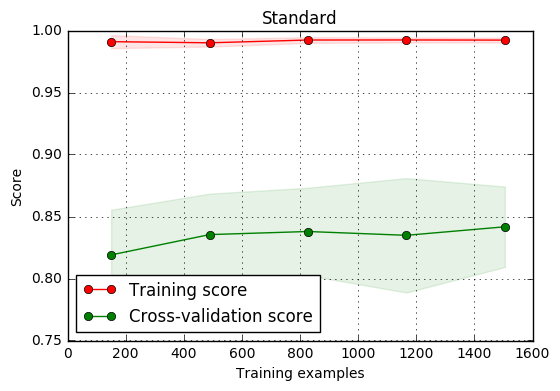

In [69]:
plotLearningCurves(clf, "Standard", data6, labels['skintone'])

This is the last estimator form part1 as you can see the accuracy cross-validation accuracy increases with the number of training examples we use. This implies that we are not overfitting which means our bias is low. You can also see that the varaince with the shading around the points is not 0 which again is a good sing that we are not overfitting. 
Now let's try to change the parameters and make the bias increase.


<module 'matplotlib.pyplot' from 'C:\\Users\\Admin\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

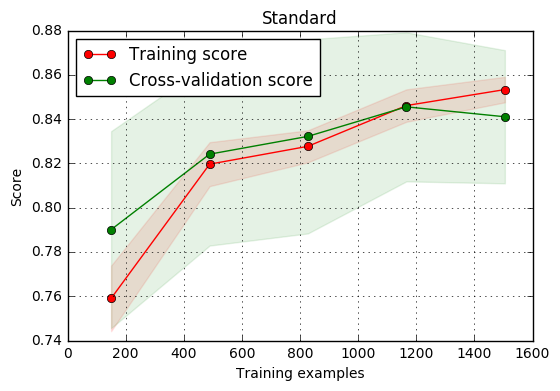

In [70]:
clf1 = RandomForestClassifier(n_estimators=1, max_features=6,  min_samples_leaf=20, max_depth=30, random_state=7)
plotLearningCurves(clf1, "Standard", data6, labels['skintone'])

We can see that the new model has a relativly high bias. At first, the cross-validation score improves with the increase in Training examples, but soon it starts decreasing, indicating that the model is overfiiting to some degree. We can also see that the variance is also very hihgh. I fixed the random_state of the Classifier so that you get the same plot with each execution.


## PART 2

In [2]:
import sklearn
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

We recuperate the aggregated dataframe we computed earlier

In [17]:
part2df = players_grouped.agg(fdict)
part2df.reset_index(inplace=True, drop=True)
part2df.head()

,victories,leagueCountry,seIAT,games,goals,defeats,ties,seExp,meanIAT,weight,club,position,height,yellowReds,yellowCards,meanExp,redCards,skintone
0,247,England,0.000652,654,9,228,179,0.004065,0.346459,71.0,Fulham FC,5,182.0,0,19,0.494575,0,0.125
1,141,Germany,0.000219,336,62,122,73,0.000993,0.348818,73.0,Werder Bremen,745,183.0,0,42,0.449220,1,0.125
2,200,England,0.000367,412,31,115,97,0.002032,0.345893,63.0,Tottenham Hotspur,746,165.0,0,11,0.491482,0,0.250
3,150,England,0.003334,260,39,68,42,0.013522,0.346821,76.0,Arsenal FC,747,178.0,0,31,0.514693,1,0.000
4,41,France,0.001488,124,1,43,40,0.005296,0.331600,73.0,Montpellier HSC,4418,180.0,4,8,0.335587,2,0.250


We only want the numeric data

In [18]:
part2df = part2df._get_numeric_data()

In [19]:
part2df.head()

,victories,seIAT,games,goals,defeats,ties,seExp,meanIAT,weight,position,height,yellowReds,yellowCards,meanExp,redCards,skintone
0,247,0.000652,654,9,228,179,0.004065,0.346459,71.0,5,182.0,0,19,0.494575,0,0.125
1,141,0.000219,336,62,122,73,0.000993,0.348818,73.0,745,183.0,0,42,0.449220,1,0.125
2,200,0.000367,412,31,115,97,0.002032,0.345893,63.0,746,165.0,0,11,0.491482,0,0.250
3,150,0.003334,260,39,68,42,0.013522,0.346821,76.0,747,178.0,0,31,0.514693,1,0.000
4,41,0.001488,124,1,43,40,0.005296,0.331600,73.0,4418,180.0,4,8,0.335587,2,0.250


We transform skintone into discrete values 0 and 1

In [20]:
part2df['skintone'] = part2df['skintone'].apply(lambda x: 1 if x>=0.5 else 0)
part2df.head()

,victories,seIAT,games,goals,defeats,ties,seExp,meanIAT,weight,position,height,yellowReds,yellowCards,meanExp,redCards,skintone
0,247,0.000652,654,9,228,179,0.004065,0.346459,71.0,5,182.0,0,19,0.494575,0,0
1,141,0.000219,336,62,122,73,0.000993,0.348818,73.0,745,183.0,0,42,0.449220,1,0
2,200,0.000367,412,31,115,97,0.002032,0.345893,63.0,746,165.0,0,11,0.491482,0,0
3,150,0.003334,260,39,68,42,0.013522,0.346821,76.0,747,178.0,0,31,0.514693,1,0
4,41,0.001488,124,1,43,40,0.005296,0.331600,73.0,4418,180.0,4,8,0.335587,2,0


We then drop rows that contain at least one NaN, because KMeans can't work with that

In [21]:
part2df.dropna(inplace=True)

In [22]:
#part2df.corr()['skintone']

We will now remove one column at a time and print the result.
First we will put skintone in first position since we don't want to drop it

In [33]:
cols = part2df.columns.tolist()
for i in range (0, len(cols)):
    if(cols[i] == 'skintone'):
        cols[0], cols[i] = cols[i], cols[0] #put skintone in first column position, put the old first column where skintone wass
shortenedDF = part2df[cols]
 #scale(shortenedDF)
shortenedDF[shortenedDF.columns[1:]]= shortenedDF[shortenedDF.columns[1:]].apply(lambda x: scale(x))
shortenedDF.head()
#shortenedDF = shortenedDF.drop('position', axis=1) #this column pretty much ruins everything so maybe we should remove it

C:\Users\Luc4s\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Luc4s\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Luc4s\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Luc4s\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Luc4s\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int

,skintone,seIAT,games,goals,defeats,ties,seExp,meanIAT,weight,position,height,yellowReds,yellowCards,meanExp,redCards,victories
0,0,0.041642,2.932516,-0.456838,3.747361,3.601954,0.256112,-0.145724,-0.708761,-0.408430,-0.006355,-0.688097,-0.507984,0.324131,-0.755506,1.811847
1,0,-0.377080,0.692276,0.814036,1.163363,0.477676,-0.395449,0.030067,-0.427201,-0.305393,0.141991,-0.688097,0.411237,-0.150731,-0.010480,0.443326
2,0,-0.233600,1.227679,0.070694,0.992722,1.185060,-0.175018,-0.187913,-1.835001,-0.305254,-2.528231,-0.688097,-0.827713,0.291746,-0.755506,1.205050
3,0,2.635461,0.156872,0.262524,-0.153013,-0.436028,2.261776,-0.118738,-0.004861,-0.305115,-0.599738,-0.688097,-0.028390,0.534771,-0.010480,0.559521
4,0,0.850192,-0.801218,-0.648668,-0.762446,-0.494976,0.517212,-1.252946,-0.427201,0.206032,-0.303046,2.179815,-0.947611,-1.340466,0.734547,-0.847731


 We now start dropping one column at a time and cluster after each step

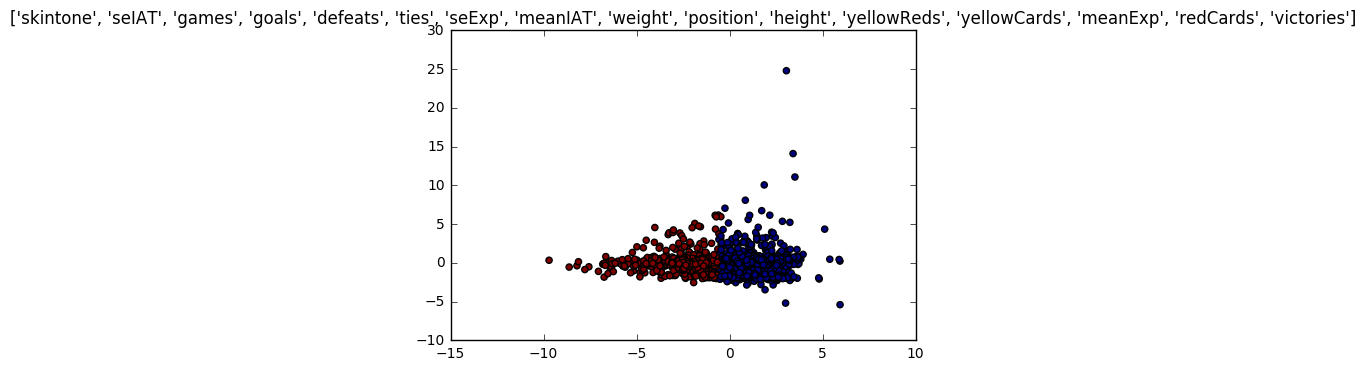

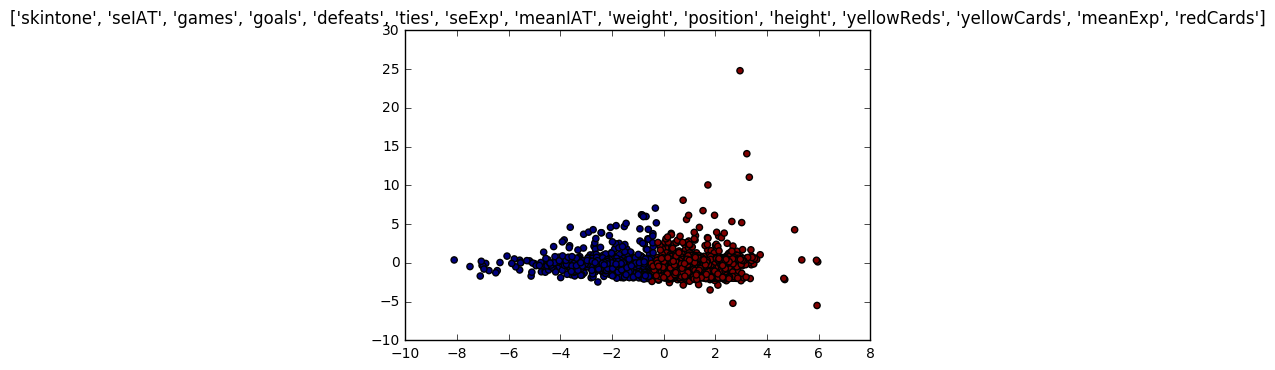

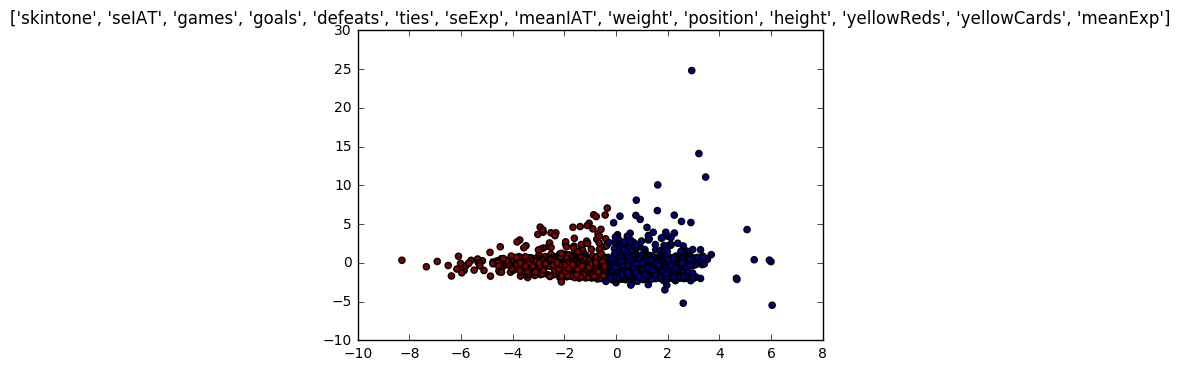

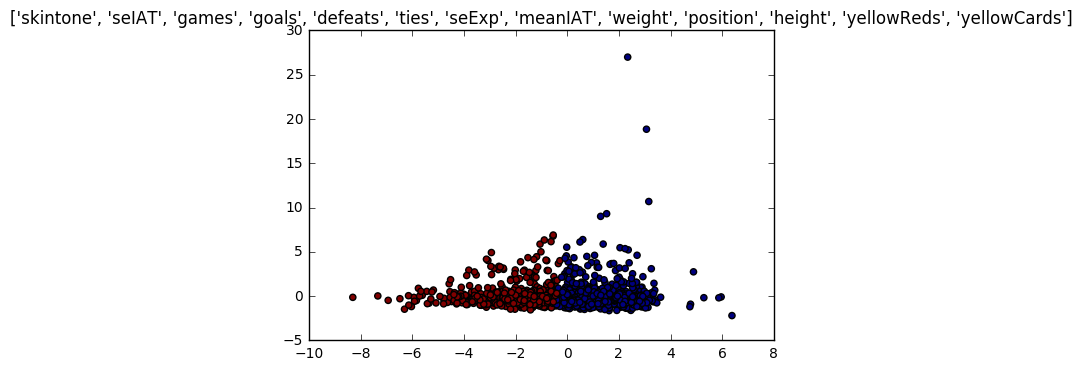

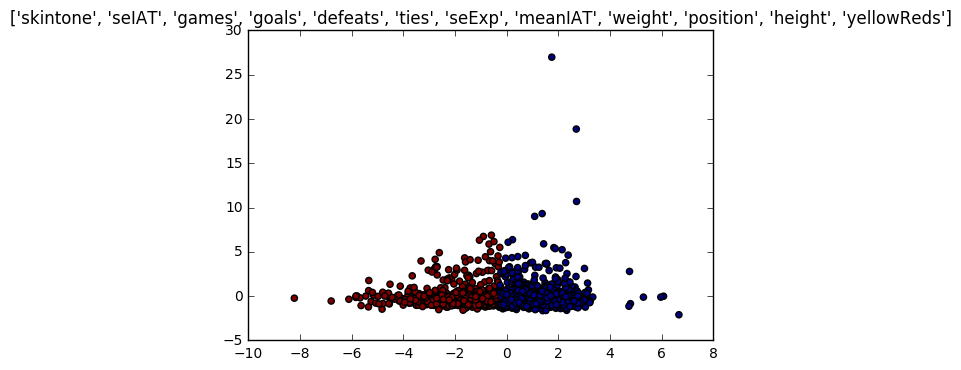

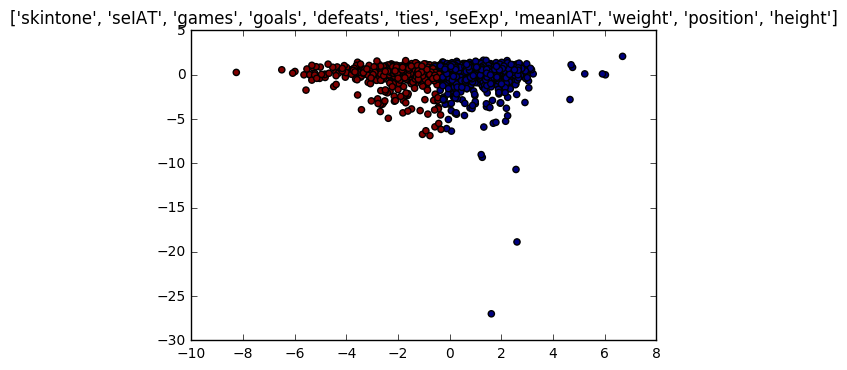

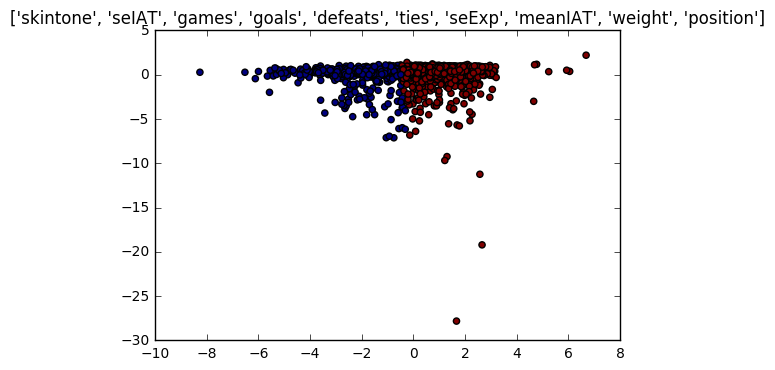

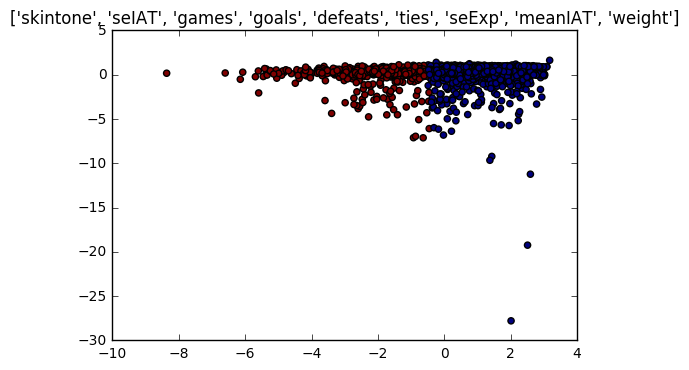

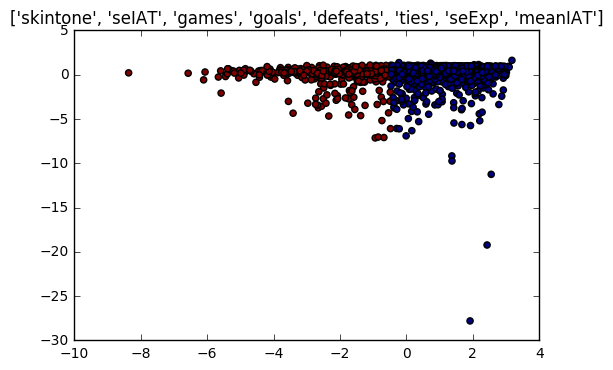

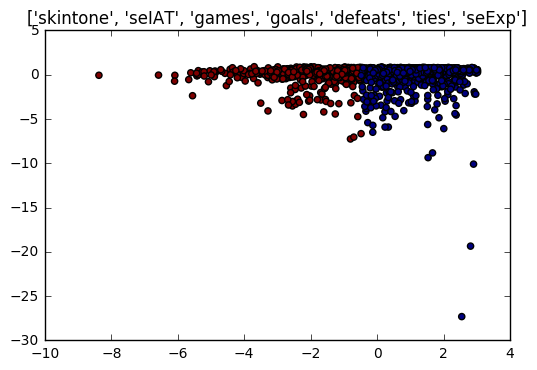

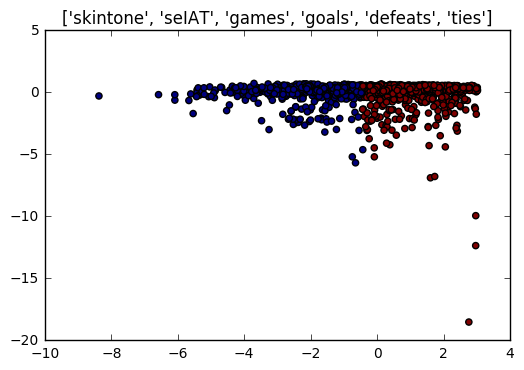

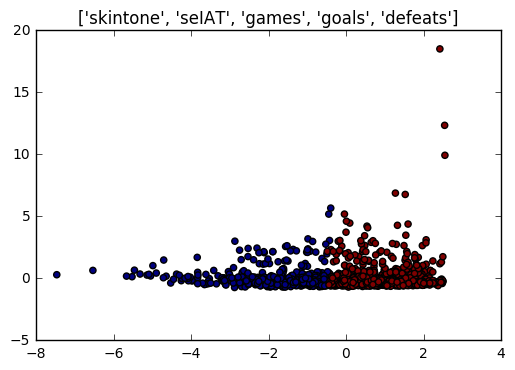

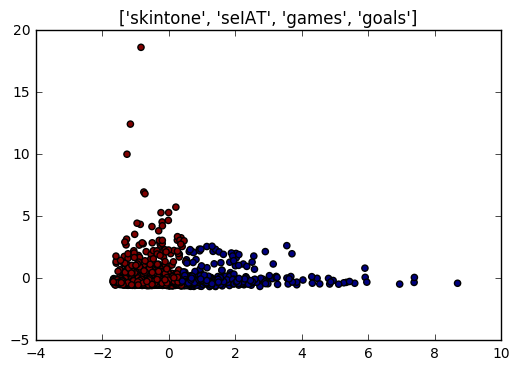

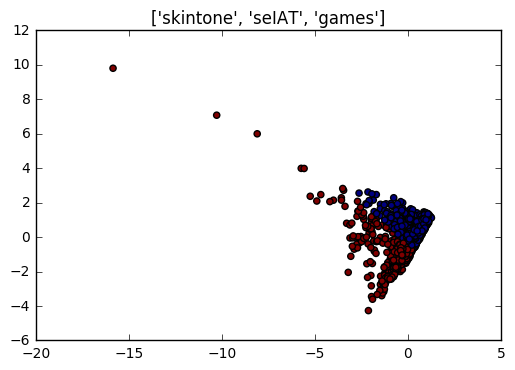

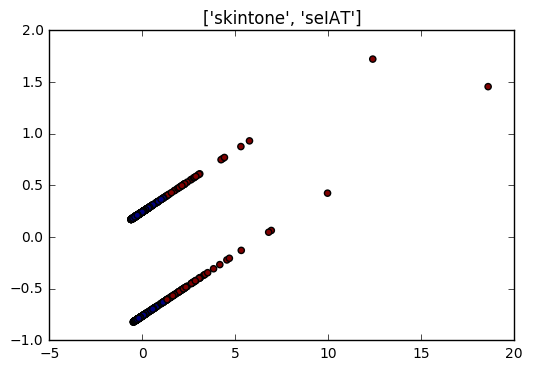

In [39]:
kmean = KMeans(n_clusters=2, init='k-means++', n_init=10, max_iter=300, tol=0.0001, precompute_distances='auto', verbose=0, random_state=None, copy_x=True, n_jobs=1)
pca_2 = PCA(2)

silhouette_scores = []
avg_skintones = []

for i in range (shortenedDF.shape[1],  1, -1):
    data = shortenedDF.ix[:,0:i]
    #shortenedDF = shortenedDF.drop(shortenedDF.columns[i], axis=1)
    kmean.fit(data)
    labels = kmean.labels_
    silhouette_scores.append(sklearn.metrics.silhouette_score(data, labels, metric='euclidean'))
    avg_skintones.append(data.groupby(labels).mean()['skintone'].values)
    #We'll now use "principal component analysis" to plot the output, PCA tries to merge the columns to be able to print them in 2D while keeping the structure of the multidimensional clusters
    plot_columns = pca_2.fit_transform(data)
    plt.scatter(x=plot_columns[:,0], y=plot_columns[:,1], c=labels)
    plt.title(data.columns.tolist())
    plt.show()

In [85]:
silhouette_scores

[0.23994070229063716,
 0.24438034427784736,
 0.22241037442998363,
 0.23273068532939437,
 0.25289650824257343,
 0.27311353966266633,
 0.28409054269372808,
 0.2924237614103225,
 0.27100976267087817,
 0.32000507629669167,
 0.38823724084426964,
 0.38191286728224549,
 0.38315668609867404,
 0.43233799113189247,
 0.60635817041186268]

In [86]:
avg_skintones

[array([ 0.22727273,  0.24903475]),
 array([ 0.22263451,  0.25170732]),
 array([ 0.2287695 ,  0.24924012]),
 array([ 0.25226131,  0.22319859]),
 array([ 0.22631579,  0.25050302]),
 array([ 0.22564103,  0.25127681]),
 array([ 0.25280326,  0.22298456]),
 array([ 0.255     ,  0.21808511]),
 array([ 0.22302158,  0.25198413]),
 array([ 0.22302158,  0.25198413]),
 array([ 0.22302158,  0.25198413]),
 array([ 0.21503132,  0.25345622]),
 array([ 0.23029046,  0.24676525]),
 array([ 0.23739496,  0.24356618]),
 array([ 0.23313407,  0.26717557])]

It would seem the repartition of skintone per cluster is pretty much equivalent for all of them, but we observe that the removal of some features decreased the silhouette score. We will then do the same but trying to maximise the silhouette score.

In [54]:
data = shortenedDF
converged = False
score = -1
kmean.fit(data)
labels = kmean.labels_
score = sklearn.metrics.silhouette_score(data, labels, metric='euclidean')
counter = 0
while not converged:
    converged = True
    for i in range (data.shape[1]-1,  1, -1):
        counter += 1
        temp = data.drop(data.columns[i], axis=1)
        kmean.fit(temp)
        labels = kmean.labels_
        new_score = sklearn.metrics.silhouette_score(temp, labels, metric='euclidean')
        if new_score > score:
            score = new_score
            data = temp
            converged = False

print(str(counter) + " iterations")

23 iterations


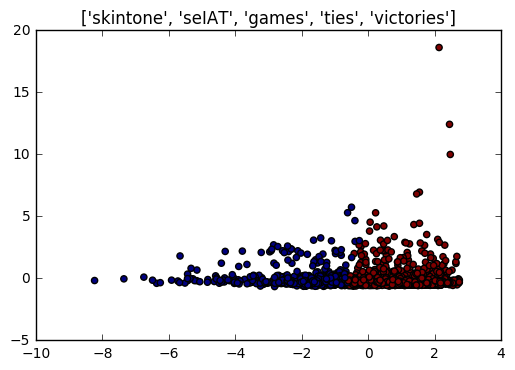

Silhouette score: 0.462388297531


0  count     494.000000
   mean        0.226721
   std         0.419135
   min         0.000000
   25%         0.000000
   50%         0.000000
   75%         0.000000
   max         1.000000
1  count    1070.000000
   mean        0.248598
   std         0.432402
   min         0.000000
   25%         0.000000
   50%         0.000000
   75%         0.000000
   max         1.000000
Name: skintone, dtype: float64

In [52]:
plot_columns = pca_2.fit_transform(data)
plt.scatter(x=plot_columns[:,0], y=plot_columns[:,1], c=labels)
plt.title(data.columns.tolist())
plt.show()
print("Silhouette score: " + str(score))
data.groupby(labels)['skintone'].describe()

We ended up with a clustering of a quite good score (0.46) but as we observe in the clusters, the standard deviation of skintone is quite huge but this is related to the fact that skintone is either 0 or 1, but quantile are useful as they show us that in both clusters, at least 75% have a light colored skin (and thus no separation between clusters in terms of skincolor).

In the previous results, we focused on the silhouette score without actually trying to improve the skintone separation. This time we will do the similar heuristic approach, but now we will try to maximize the skintone mean difference between clusters.

In [62]:
data = shortenedDF
converged = False
score = -1
kmean.fit(data)
labels = kmean.labels_
score = sklearn.metrics.silhouette_score(data, labels, metric='euclidean')
means = data.groupby(labels)['skintone'].mean()
mean_diff = abs(means[0] - means[1])  

while not converged:
    converged = True
    for i in range (data.shape[1]-1,  1, -1):
        temp = data.drop(data.columns[i], axis=1)
        kmean.fit(temp)
        labels = kmean.labels_
        new_score = sklearn.metrics.silhouette_score(temp, labels, metric='euclidean')
        means = data.groupby(labels)['skintone'].mean()
        if abs(means[0] - means[1]) > mean_diff:
            score = new_score
            data = temp
            mean_diff = abs(means[0] - means[1])
            converged = False

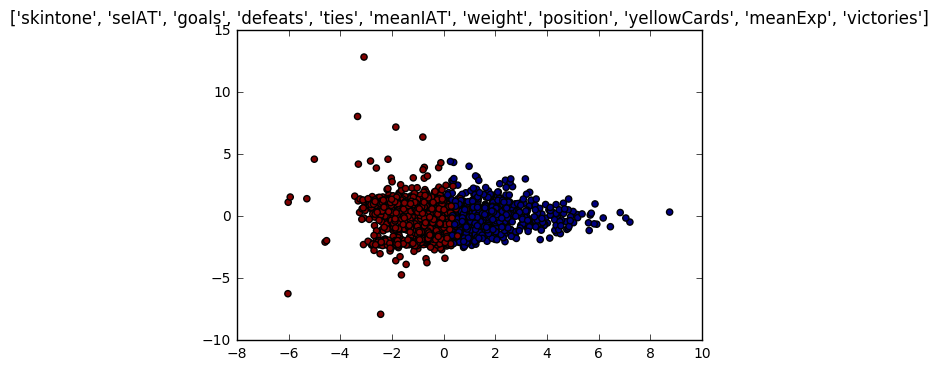

Silhouette score: 0.242796564844


0  count    581.000000
   mean       0.213425
   std        0.410078
   min        0.000000
   25%        0.000000
   50%        0.000000
   75%        0.000000
   max        1.000000
1  count    983.000000
   mean       0.258393
   std        0.437974
   min        0.000000
   25%        0.000000
   50%        0.000000
   75%        1.000000
   max        1.000000
Name: skintone, dtype: float64

In [63]:
plot_columns = pca_2.fit_transform(data)
plt.scatter(x=plot_columns[:,0], y=plot_columns[:,1], c=labels)
plt.title(data.columns.tolist())
plt.show()
print("Silhouette score: " + str(score))
data.groupby(labels)['skintone'].describe()

This time we separated by skintone more efficiently and even achieved to have 25% of black people in cluster 1! But in the other way we reduced the silhouette score to 0.24 (compared to 0.46 before). In conclusion to this, it clearly seems that trying to split players by their skin colors does not give significant results.